In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


In [2]:
import matplotlib.pyplot as plt


In [144]:
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras.layers import Activation,BatchNormalization,Flatten,MaxPooling2D,ZeroPadding2D
from tensorflow.keras.layers import Input,Conv2D,Conv2DTranspose,Dense,Reshape,Dropout,UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

from scipy import misc
import numpy as np
import os
import numpy as np


def compute_mse(a,b):
    A = a.flatten()
    B = b.flatten()
    mse = mean_squared_error(A,B)
    return mse

def compute_ssim(a,b):
    ssim = []
    num_imgs = a.shape[0]
    for i in range(num_imgs):
        ssim.append( SSIM(a[i],b[i],
                      data_range=(1-(-1)),
                      multichannel=True))

    # dssim
    return ( 1 - np.array(ssim).mean() ) / 2

class CEncoder():
    def __init__(self):
        self.img_rows = 128
        self.img_cols = 128
        self.mask_height = 64
        self.mask_width = 64
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.patch_shape = (self.mask_height,self.mask_width,self.channels)
        self.overlap = 7

        lambda_recon = 0.999
        lambda_adv = 0.001
        optimizer_recon = Adam(lr=2e-3, beta_1=0.5,decay=1e-2)
        optimizer_adv = Adam(lr=2e-3, beta_1=0.5,decay=1e-3)

        self.gf = 64
        self.df = 64 # masked patch size

        # Construct autoencoder
        self.autoencoder = self.build_autoencoder()
        # Construct discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer_adv, metrics=['accuracy'])
        # Construct GAN
        masked_img = Input(shape=self.img_shape)
        #gen_missing = self.autoencoder(masked_img)
        gen_missing = self.autoencoder(masked_img)

        self.discriminator.trainable = True

        valid = self.discriminator(gen_missing)

        self.combined = Model(masked_img, [gen_missing, valid])
        self.combined.compile(loss=['mse','binary_crossentropy'],
            loss_weights=[lambda_recon,lambda_adv],
            optimizer=optimizer_recon,
            metrics=['accuracy'])

    """ Building models """
    def build_autoencoder(self):
        def conv_bn_relu_pool(input_layer,filters,kernel_size=4,stride=2,pad='same',activation='relu'):
            y = Conv2D(filters,kernel_size=kernel_size,
                                strides=stride,padding=pad)(input_layer)

            if activation=='relu':
                y = Activation('relu')(y)
            elif activation=='lrelu':
                y = tf.keras.layers.LeakyReLU(alpha=0.2)(y)
            else:
                print("WARNING: no activation layer")
                pass
            y = BatchNormalization()(y)
            output = y
            return output
        def deconv_bn_relu(input_layer,filters,kernel_size=4,stride=2,pad='same', activation='relu'):
            y = Conv2DTranspose(filters,kernel_size=kernel_size,
                                strides=stride,padding=pad)(input_layer)
            if activation=='relu':
                y = Activation('relu')(y)
            elif activation=='lrelu':
                y = tf.keras.layers.LeakyReLU(alpha=0.2)(y)
            else:
                input("WARNING: no activation layer <Enter to continue>")
                pass
            y = BatchNormalization()(y)
            output = y
            return output


        # AlexNet
        input = Input(shape=self.img_shape)

        y = conv_bn_relu_pool(input,filters=self.gf,activation='lrelu')
        y = conv_bn_relu_pool(y,filters=self.gf,activation='lrelu')
        y = conv_bn_relu_pool(y,filters=self.gf*2,activation='lrelu')
        y = conv_bn_relu_pool(y,filters=self.gf*4,activation='lrelu')
        y = conv_bn_relu_pool(y,filters=self.gf*8,activation='relu')
        latent = conv_bn_relu_pool(y,filters=4000,stride=1,pad='valid',activation='lrelu') # increase to 4000
        latent = Dropout(0.5)(latent)

        y = deconv_bn_relu(latent,filters=self.df*8,stride=1,pad='valid',activation='relu')
        y = deconv_bn_relu(y,filters=self.df*4,activation='relu')
        y = deconv_bn_relu(y,filters=self.df*2,activation='relu')
        y = deconv_bn_relu(y,filters=self.df,activation='relu')

        y = Conv2DTranspose(3,kernel_size=4,strides=2,padding='same')(y)
        output = Activation('tanh')(y)

        model = Model(input,output)
        model.summary()
        return model

    def build_discriminator(self):
        def conv_bn_relu_pool(input_layer,filters,kernel_size=4,stride=2,pad='same',activation='relu'):
            y = Conv2D(filters,kernel_size=kernel_size,
                        strides=stride,padding=pad)(input_layer)
            if activation=='relu':
                y = Activation('relu')(y)
            elif activation=='lrelu':
                y = tf.keras.layers.LeakyReLU(alpha=0.2)(y)
            else:
                print("WARNING: no activation layer")
                pass
            y = BatchNormalization()(y)
            output = y
            return output

        patch = Input(shape=self.patch_shape)
        y = conv_bn_relu_pool(patch,filters=self.df,activation='lrelu')
        y = conv_bn_relu_pool(y,filters=self.df*2,activation='lrelu')
        y = conv_bn_relu_pool(y,filters=self.df*4,activation='lrelu')
        y = conv_bn_relu_pool(y,filters=self.df*8,activation='lrelu')

        y = Flatten()(y)
        validity = Dense(1,activation='sigmoid')(y) # review activation here
        model = Model(patch,validity)

        model.summary()
        return model

    
    
    def train(self, generator,max_iter=1, batch_size=128,start_iter=0):
        
        step_counter=start_iter
        
        half_batch = int(batch_size / 2)
        
        while(step_counter<max_iter):
            for _, x_batch_train in enumerate(generator):
                step_counter+=1
                
                imgs,masked,missings = x_batch_train
        
                idx = np.random.choice(range(batch_size), size=half_batch, replace=False, p=None)
                half_imgs = np.array([imgs[i] for i in idx])
                half_masked = np.array([masked[i] for i in idx])
                half_missing = np.array([missings[i] for i in idx])
                
                
                # ---------------------
                #  Train Discriminator
                # ---------------------
                
            
                gen_missing = self.autoencoder.predict(half_masked)
                valid = np.ones((half_batch, 1))
                fake = np.zeros((half_batch, 1))
                
                d_loss_real = self.discriminator.train_on_batch(half_missing, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_missing, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                
                # ---------------------
                #  Train Generator
                # ---------------------
              
                valid = np.ones((batch_size, 1))

                # Train the generator
                g_loss = self.combined.train_on_batch(masked, [missings, valid])
                
                
                # Plot the progress
                print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f, acc: %.2f%%]" % (step_counter, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1], 100*g_loss[4]))
            

In [145]:
#TRAIN_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_0.json","/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_1.json"]
TEST_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_3.json"]


In [146]:
ce = CEncoder()

Model: "functional_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_135 (LeakyReLU)  (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_210 (Bat (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 32, 32, 64)        65600     
_________________________________________________________________
leaky_re_lu_136 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_211 (Bat (None, 32, 32, 64)      

In [ ]:
ce.train(damaged_generator)

1 [D loss: 0.093120, acc: 96.09%] [G loss: 0.089861, mse: 0.089893, acc: 98.44%]
2 [D loss: 0.126324, acc: 94.53%] [G loss: 0.094767, mse: 0.094846, acc: 100.00%]
3 [D loss: 0.038840, acc: 98.44%] [G loss: 0.099822, mse: 0.099920, acc: 100.00%]
4 [D loss: 0.024882, acc: 99.22%] [G loss: 0.097268, mse: 0.097365, acc: 100.00%]
5 [D loss: 0.205885, acc: 90.62%] [G loss: 0.092023, mse: 0.091792, acc: 89.84%]
6 [D loss: 1.351614, acc: 65.62%] [G loss: 0.084780, mse: 0.083542, acc: 68.75%]
7 [D loss: 0.402863, acc: 85.94%] [G loss: 0.086186, mse: 0.085346, acc: 73.44%]
8 [D loss: 0.362519, acc: 86.72%] [G loss: 0.104637, mse: 0.104331, acc: 85.16%]
9 [D loss: 0.253716, acc: 92.97%] [G loss: 0.089812, mse: 0.089731, acc: 92.97%]
10 [D loss: 0.058611, acc: 97.66%] [G loss: 0.090933, mse: 0.090967, acc: 97.66%]
11 [D loss: 0.116603, acc: 95.31%] [G loss: 0.104230, mse: 0.104314, acc: 99.22%]
12 [D loss: 0.036912, acc: 99.22%] [G loss: 0.105242, mse: 0.105345, acc: 100.00%]
13 [D loss: 0.030254,

In [5]:
# DATASETS

In [141]:
from getData import get_generator
damaged_generator = get_generator(TEST_DATASET,128,128,damaged=False,dim_missing=64)
#non_damaged_generator = get_generator(TEST_DATASET,10,128,damaged=False,)

In [142]:
img,masked,missing = damaged_generator.__getitem__(5)

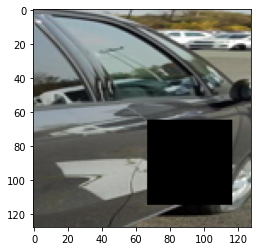

In [158]:
plt.imshow((masked[2]+1)/2)

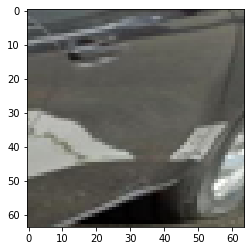

In [159]:
plt.imshow((missing[2]+1)/2)

In [154]:
res = ce.autoencoder.predict(masked)

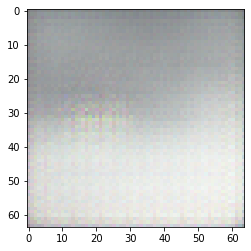

In [157]:
plt.imshow((res[1]+1)/2)

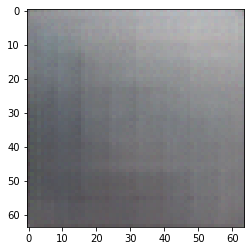

In [138]:
plt.imshow((res[0]+1)/2)

In [ ]:
new_img = 